# Grapheme Embedding Using PyTorch

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torch.backends.cudnn as cudnn
import tqdm

import re
import numpy as np
import os
import matplotlib.pyplot as plt
from random import randint

In [2]:
text = open("graphemes.txt")
processed_text = (re.sub(r'[^\w\s]','',text.read().lower()))

vocab = list('abcdefghijklmnopqrstuvwxyz$£')

tokens = [list("$$"+token+"£") for token in processed_text.split('\n') if set(token)&set(vocab)==set(token)]


v = len(vocab)

## Byte Pair Encoding

In [150]:
pairFreqs={}
replacements = {}

for i in range(10):
    print(i)
    tempTokens = []
    for token in tokens:
        if i!=0:
            token = list(''.join(token).replace(topOc,str(i-1)))
        for g in range(2,len(token)-2):
            pair = (token[g]+token[g+1])
            if pair in pairFreqs.keys():
                pairFreqs[pair] += 1
            else:
                pairFreqs[pair] = 1
        tempTokens.append(token)
        
    tokens = tempTokens
    topOcs = [(k, v) for k, v in sorted(pairFreqs.items(), key=lambda item: item[1],reverse=True)]
    topOc = (topOcs[0][0])
    
    replacements[i] = topOc
print(topOc)

0
1
2
3
4
5
6
7
8
9
en


In [151]:
replacements

{0: 'er',
 1: 'in',
 2: 'es',
 3: 'es',
 4: 'on',
 5: 'at',
 6: 'an',
 7: 'ed',
 8: 'is',
 9: 'en'}

### Helper functions

In [10]:
def graph2int(graph):
    return vocab.index(graph)
    
def int2graph(index):
    return vocab[index]

def int2vec(integer):
    vec=torch.zeros(len(vocab))
    vec[integer]=1
    return vec

def graph2vec(graph):
    return (int2vec(graph2int(graph)))

def vec2graph(vec):
    return (int2graph(np.argmax(vec)))

In [11]:
windowSize = 2
tokens = [tokenSet for tokenSet in tokens if len(tokenSet)>=6]

In [376]:
x_data = torch.empty(size=(1,2,28))
y_data = torch.empty(size=(1,1))

freqs= torch.zeros(size=(1,28))

i=0
N=len(tokens)
for word in tqdm.tqdm(tokens):
    wc = len(word)
    for graph_i in range(wc-2): 
        data_sample =torch.stack((graph2vec(word[graph_i]), graph2vec(word[graph_i+1]))).unsqueeze(0)
        x_data = torch.cat((x_data,data_sample),0)
        label_sample = torch.tensor([graph2int(word[graph_i+2])]).unsqueeze(0).float()
        y_data = torch.cat([y_data,label_sample])
        freqs += graph2vec(word[graph_i+2])
        
    

 18%|█▊        | 13515/75839 [15:42<1:12:28, 14.33it/s]


KeyboardInterrupt: 

In [12]:
x_data=torch.load('EnglishData.pt')
y_data=torch.load('EnglishLabels.pt')
freqs=torch.load('EnglishFreqs.pt')

In [7]:
print(x_data.shape)
print(y_data.shape)
freqs

torch.Size([129814, 2, 28])
torch.Size([129814, 1])


tensor([[ 9178.,  2287.,  4582.,  4086., 13151.,  1543.,  3029.,  2678.,  9765.,
           244.,  1084.,  6388.,  3181.,  7922.,  7128.,  3158.,   197.,  8997.,
         11110.,  7605.,  4113.,  1152.,  1065.,   309.,  1857.,   490.,     0.,
         13515.]])

## PyTorch

### Encoder

In [13]:
class Encoder(nn.Module):
    def __init__(self,grapheme_shape,hidden_units,embedding_units):
        super(Encoder,self).__init__()
        self.word_shape = grapheme_shape
        self.hidden_units = hidden_units
        self.embedding_units = embedding_units
        
        self.weights_1 = nn.Parameter(torch.empty(size=(hidden_units, grapheme_shape), requires_grad=True))
        nn.init.normal_(self.weights_1)
        
        self.weights_2 = nn.Parameter(torch.empty(size=(embedding_units, hidden_units), requires_grad=True))
        nn.init.normal_(self.weights_2)
        
        self.bias1 = nn.Parameter(torch.zeros(hidden_units), requires_grad=True)
        self.bias2 = nn.Parameter(torch.zeros(embedding_units), requires_grad=True)

    def forward(self,inputs):
        out = F.linear(inputs, self.weights_1, self.bias1)
        out = nn.ReLU().forward(out)
        out = F.linear(out, self.weights_2,self.bias2)
        out = nn.ReLU().forward(out)
        return out
    

        

### Decoder

In [14]:
class Decoder(nn.Module):
    def __init__(self,embedding_units,hidden_dim,grapheme_shape,encoder):
        super(Decoder,self).__init__()
        self.e = encoder
        self.embedding_units=embedding_units
        self.hidden_dim = hidden_dim
        
        self.n_layers=2
        self.rnn = nn.LSTM(self.embedding_units, hidden_dim,self.n_layers, batch_first=True)   
        self.fc = nn.Linear(hidden_dim, grapheme_shape)
        self.bias = nn.Parameter(torch.zeros(grapheme_shape), requires_grad=True)
        
        embedding = torch.randn(256,1,self.embedding_units)

        h0 = torch.randn(self.n_layers,256,self.hidden_dim)
     
        hidden, output = self.rnn.forward(embedding, h0)
      
    def forward(self,inputs):
        #print(inputs.shape)
        embedding1 = self.e.forward(inputs[:,0])
        embedding2 = self.e.forward(inputs[:,1])
        embeddings = torch.stack((embedding1,embedding2),dim=1)
        #print(embeddings.shape)
        
        hidden = torch.randn(self.n_layers,inputs.shape[0], self.hidden_dim)
        output,hidden = self.rnn.forward(embeddings,hidden)
        
        out = self.fc.forward(output)
        #print(out.shape)
        return out[:,-1,:]
    
    def encode(self,inputs):
        return self.e.forward(inputs)


In [364]:
rnn = nn.RNN(10, 20, 2)         # rnn with input size 10, hidden size 20, and 2 rnn layers
input = torch.randn(5, 3, 10)   # input 5 batches of shape 3,10
h0 = torch.randn(2, 3, 20)      # two rnn layers of shape 3,20

print(input.shape)
print(h0.shape)

output, hn = rnn(input, h0)     # output 5 batches of shape 3,20
print(output.shape)

torch.Size([5, 3, 10])
torch.Size([2, 3, 20])
torch.Size([5, 3, 20])


In [15]:
train_ratio = 0.80
batch_size = 256

trn_n = int(x_data.shape[0] * 0.8)
batches = (int(trn_n/batch_size))

x_trn = x_data[:trn_n,:,:].clone()
y_trn = y_data[:trn_n,:].clone()

x_val = x_data[trn_n:,:,:].clone()
y_val = y_data[trn_n:,:].clone()

In [16]:
metric_dict = {'losses_trn': [],'losses_val':[]} 
embed_units = 20
encoder =  Encoder(grapheme_shape=v,hidden_units=15,embedding_units=embed_units)
decoder = Decoder(embedding_units=embed_units,hidden_dim=20,grapheme_shape=v,encoder=encoder)

RuntimeError: Expected hidden[0] size (2, 256, 20), got (256, 20)

In [385]:
optimizer = optim.Adam(decoder.parameters(), amsgrad=False, weight_decay=0.0,lr=0.005)

trn_loss = nn.NLLLoss(weight=freqs.float())
val_loss = nn.NLLLoss()

for epoch in range(100):
    print("Epoch:" + str(epoch))
    epoch_trn_loss_sum = 0
    for batch in (range(batches)):
        x_batch = x_trn[batch_size*batch:batch_size*(batch+1)]
        y_batch = y_trn[batch_size*batch:batch_size*(batch+1)]
        
        out = decoder.forward(x_batch)
        log_softmax = F.log_softmax(out, dim=1).unsqueeze(2)
       # print(log_softmax.shape)
       

      
        NLL_Loss = trn_loss(log_softmax,y_batch.long()) 
        optimizer.zero_grad()
        NLL_Loss.backward()
        optimizer.step()
        epoch_trn_loss_sum += NLL_Loss.item()

    out_val = decoder.forward(x_val)
    log_val_softmax = F.log_softmax(out_val, dim=1).unsqueeze(2)
    NLL_val_loss = trn_loss(log_val_softmax, y_val.long())
    
    epoch_trn_loss = epoch_trn_loss_sum/batches
    print("Validation Loss: "+str(NLL_val_loss.item()))
    print("Train Loss:      "+str(epoch_trn_loss))
    print("\n")
   # print("Val: "+str(val_loss.item()))
    metric_dict['losses_trn'].append(NLL_Loss.item())
    metric_dict['losses_val'].append(epoch_trn_loss)

Epoch:0
Validation Loss: 2.040922164916992
Train Loss:      2.1882235594737676


Epoch:1
Validation Loss: 2.002100706100464
Train Loss:      2.0164725889394313


Epoch:2
Validation Loss: 1.986512303352356
Train Loss:      1.9898815852624399


Epoch:3
Validation Loss: 1.9745442867279053
Train Loss:      1.9782092803790245


Epoch:4
Validation Loss: 1.967623233795166
Train Loss:      1.970267387378363


Epoch:5
Validation Loss: 1.9654531478881836
Train Loss:      1.9641549437134354


Epoch:6
Validation Loss: 1.9614325761795044
Train Loss:      1.9598685526553496


Epoch:7
Validation Loss: 1.9577784538269043
Train Loss:      1.954815368004787


Epoch:8
Validation Loss: 1.9579503536224365
Train Loss:      1.9523080755163122


Epoch:9
Validation Loss: 1.9520522356033325
Train Loss:      1.949801895942217


Epoch:10
Validation Loss: 1.9510823488235474
Train Loss:      1.9477024328561476


Epoch:11
Validation Loss: 1.9516372680664062
Train Loss:      1.9458886170092924


Epoch:12
Validation L

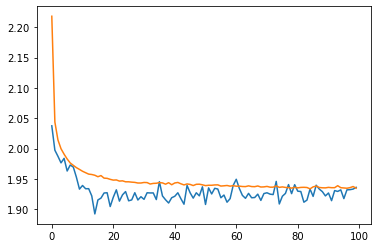

In [323]:
plt.plot(metric_dict['losses_trn'][:100])
plt.plot(metric_dict['losses_val'][:100])

In [327]:
embeddings = np.zeros(shape=(len(vocab),15))

i=0
for grapheme in vocab:
    test = graph2vec(grapheme)
    embedding = decoder.encode(test).detach().numpy()
    embeddings[i,:]=embedding
    i+=1



embedding_means = embeddings.mean(axis=0)
embedding_std = embeddings.std(axis=0)
norm_embeddings = (embeddings-embedding_means)/embedding_std

    
covariance_matrix = np.cov(norm_embeddings.T)
v,w = np.linalg.eig(covariance_matrix)

idx = v.argsort()[::-1] # Sort descending and get sorted indices
v = v[idx] # Use indices on eigv vector
w = w[:,idx] # 

variance_explained = []
for i in v:
     variance_explained.append((i/sum(v))*100)
        
red_Vecs = w[0:2,:]

low_d_embed = (embeddings @ red_Vecs.T)

#plt.scatter(x=low_d_embed[:,0],y=low_d_embed[:,1])

x=low_d_embed[:,0]
y=low_d_embed[:,1]

fig, ax = plt.subplots()
ax.scatter(x, y,color='white')

for i, txt in enumerate(vocab):
    ax.annotate(txt, (x[i], y[i]))

/Users/timlongley/opt/anaconda3/envs/project/lib/python3.7/site-packages/ipykernel_launcher.py:14: RuntimeWarning: invalid value encountered in true_divide
  


LinAlgError: Array must not contain infs or NaNs

In [325]:
n=randint(0,x_trn.shape[0])



input = x_trn[n,:,:].unsqueeze(0)
output = y_trn[n,:]

out=decoder.forward(input)
log_softmax = -F.log_softmax(out, dim=1)

p=(log_softmax.argmin(dim=1).detach().numpy()[0])
o=(output.int().numpy())

numpy_input = input.int().detach().numpy()[0]
inp_ind = (numpy_input.argmax(axis=1))
inp_let = [vocab[i] for i in inp_ind]


print(inp_let)
print("Prediction: " + ''.join(inp_let)+" "+str(vocab[p]))
print("True:       " + ''.join(inp_let)+" "+str(vocab[o[0]]))

['n', 'd']
Prediction: nd e
True:       nd u


In [390]:
n=randint(0,len(tokens))
token=(tokens[n])[:-1]
print(token)

input = token[-3:-1]


#input = x_trn[n,:,:].unsqueeze(0)
output = token[-1:][0]

input = torch.tensor([graph2vec(input[0]),graph2vec(input[1])]).unsqueeze(0).float()

out=decoder.forward(input)
log_softmax = -F.log_softmax(out, dim=1)

p=(log_softmax.argmin(dim=1).detach().numpy()[0])
o=(output)

numpy_input = input.int().detach().numpy()[0]
inp_ind = (numpy_input.argmax(axis=1))
inp_let = [vocab[i] for i in inp_ind]
print(inp_let)
print(p)


print(inp_let)
print("Prediction: " + ''.join(token[:-1])+" "+str(vocab[p]))
print("True:       " + ''.join(token[:-1])+" "+str(output))


['$', '$', 'p', 'r', 'i', 'm', 'u', 'l', 'a']


ValueError: only one element tensors can be converted to Python scalars

In [400]:
n=randint(0,len(tokens))
token=(tokens[n])[:-1]




for i in range(1):
    sentence = []
    for i in range(10):
        string = "$$"

        while True:

            input=string[-2:]
            input = torch.stack((graph2vec(input[0]), graph2vec(input[1]))).unsqueeze(0)

            out=decoder.forward(input)
            probs = F.softmax(out, dim=1).detach().numpy()[0]

            sample = np.random.multinomial(1, probs)

            ids = np.argmax(sample)
            grapheme = str(vocab[ids])
            #p=(log_softmax.argmin(dim=1).detach().numpy()[0])

            if grapheme=="$":
                continue
            string+=grapheme
            if grapheme =="£":
                break

        string = string.split('$')[2:][0]
        string = string.split('£')[:-1][0]
        sentence.append(string)

    print(' '.join(sentence))



secenion tie nuisies saticalarrin imply tasing pas sallers unens dister


In [849]:
embeddings = np.zeros(shape=(len(vocab),10))

i=0
for grapheme in vocab:
    test = torch.from_numpy(graph2vec(grapheme)).float()
    embedding = decoder.encode(test).detach().numpy()
    embeddings[i,:]=embedding
    i+=1
    
l=0
for e in (embeddings):
    dists=(np.square(embeddings-e).sum(axis=1))
    nearest_idx=(np.argsort(dists)[1])
    print("Nearest neighbour of "+vocab[l]+" : "+vocab[nearest_idx])
    l+=1
    

Nearest neighbour of a : c
Nearest neighbour of b : p
Nearest neighbour of c : f
Nearest neighbour of d : z
Nearest neighbour of e : s
Nearest neighbour of f : x
Nearest neighbour of g : q
Nearest neighbour of h : r
Nearest neighbour of i : k
Nearest neighbour of j : w
Nearest neighbour of k : i
Nearest neighbour of l : d
Nearest neighbour of m : x
Nearest neighbour of n : r
Nearest neighbour of o : a
Nearest neighbour of p : b
Nearest neighbour of q : s
Nearest neighbour of r : n
Nearest neighbour of s : t
Nearest neighbour of t : s
Nearest neighbour of u : b
Nearest neighbour of v : $
Nearest neighbour of w : $
Nearest neighbour of x : f
Nearest neighbour of y : t
Nearest neighbour of z : £
Nearest neighbour of $ : v
Nearest neighbour of £ : z


In [122]:
'1'.isnumeric()

True

In [368]:
a = torch.zeros(3,15,100000)

In [371]:
torch.save(a,'test.pt')

In [379]:
torch.save(x_data,'EnglishData.pt')
torch.save(y_data,'EnglishLabels.pt')


In [403]:
torch.save(freqs,'EnglishFreqs.pt')